# Sparse model predictive control study

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

In [2]:
from utils.step_reference import gen_step_ref
from dyn.linear_long import LinearLong
from alg.sparse_mpc import SparseMPC

### Platoon parameters

In [3]:
H = 100   # planning horizon
dt = 0.1  # timestep
total_time = 8.0  # seconds
total_time += dt * H

# dynamics stuff
x_min = np.array([-np.inf, -np.inf, -np.inf])
x_max = np.array([np.inf, np.inf, np.inf])
u_min = np.array([-6.0])
u_max = np.array([6.0])
tau = 0.5
dyn = LinearLong(dt, x_min, x_max, u_min, u_max, tau)
n, m, p = dyn.n, dyn.m, dyn.p

# algorithm
Q = 10.0 * np.eye(n)
# Q_f = 10.0 * np.eye(n)
Q_f = np.zeros((n,n))
R = 0.1 * np.eye(m)
mpc = SparseMPC(Q, Q_f, R, dyn, u_min, u_max, x_min, x_max, H)

### Reference trajectory - Acceleration

In [4]:
dist_start = 1.0
dist_end = 2.0
v_start = 20.
v_end = 22.

x_ref, t_range = gen_step_ref(total_time, dt, dist_start, dist_end, 
                              v_start, v_end)
y_ref = x_ref[:2, :]
T = len(t_range)
t_range_mpc = t_range[:T-H]

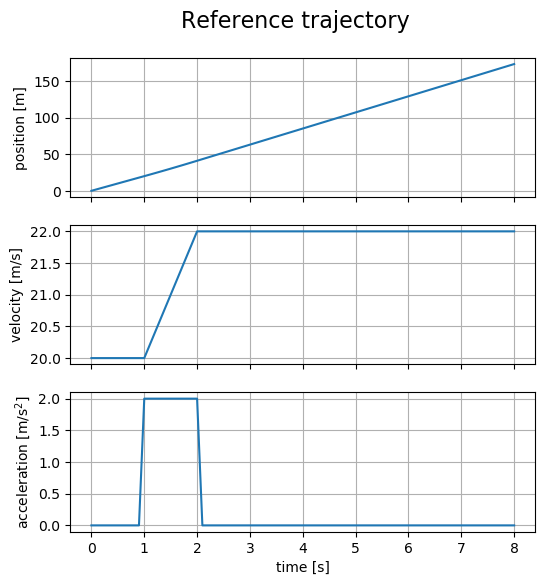

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
fig.suptitle("Reference trajectory", size=16)
fig.subplots_adjust(top=0.9)

for i in range(x_ref.shape[0]):
    ax[i].plot(t_range[:T-H], x_ref[i, :T-H])
    ax[i].grid()
ax[0].set_ylabel("position [m]")
ax[1].set_ylabel("velocity [m/s]")
ax[2].set_ylabel(r"acceleration [m/s$^2$]")
ax[2].set_xlabel("time [s]");

### Leader reference tracking

In [6]:
start_time = time.time()
x_track = np.zeros((n, T-H))
x_track[:, 0] = x_ref[:, 0]
for k in tqdm(range(T - H - 1)):
    z = x_ref[:, k:k+H+1]
    x_0 = x_track[:, k]

    y_opt, prob = mpc.control(x_0, z, x_f = z[:, -1])
    if prob.status != 'optimal':
        print(f"timestep {k}, problem returned: {prob.status}")
        break
    
    u_opt = np.zeros((m, H))
    x_opt = np.zeros((n, H+1))
    x_opt[:, 0] = x_0
    for t, i in enumerate(range(0, H*(n+m), n+m)):
        u_opt[:, t] = y_opt[i:i+m]
        x_opt[:, t+1] = y_opt[i+m:i+m+n] + z[:, t+1]
    
    x_track[:, k+1] = dyn.forward(x_0, u_opt[:, 0])

100%|██████████| 80/80 [00:00<00:00, 91.13it/s]


In [7]:
end_time = time.time()
avg_time = (end_time - start_time) / (T - H)

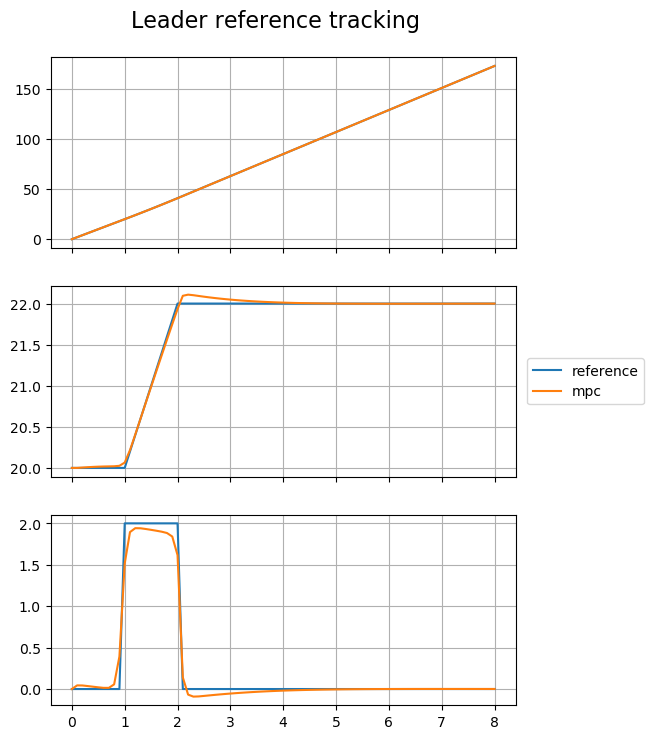

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(6, 8), sharex=True)
fig.suptitle("Leader reference tracking", size=16)
fig.subplots_adjust(top=0.92)

for i in range(x_ref.shape[0]):
    ax[i].plot(t_range_mpc, x_ref[i, :T-H], label="reference")
    ax[i].plot(t_range_mpc, x_track[i, :], label="mpc")
    ax[i].grid()
ax[1].legend(bbox_to_anchor=(1.01, 0.5), loc="center left");